# TPT pipeline with ERA5 and S2S

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs

In [3]:
%load_ext autoreload

In [4]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils

In [5]:
import matplotlib
from matplotlib import ticker
matplotlib.rcParams.update({"font.size": 15})
matplotlib.rcParams["font.family"] = 'monospace'
%matplotlib inline

# Set up experiment

In [6]:
create_eofs_flag =                   0
featurize_flag =                     0
recombine_features_flag =            1

In [7]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-08-23"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-08-23"),
                #"filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-08-23",),
                #"filename": "era5_features_tpt.nc",
            }),
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "s2s_data", "stats", "2022-08-25"),
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "s2s_data", "features_all", "2022-08-25"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "s2s_data", "features_tpt", "2022-08-25",),
                "filename": "s2s_features_tpt.nc",
            }),
        })    }),
    "results": dict({
        "dir": join(topic_dir, "results", "tpt_quantities", "2022-08-23")
    })
})

In [8]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

# Define EOFs

Compute from data between October and March

In [ ]:
trajdir = filedict["data"]["e5"]["traj"]["dir"]
file_list = [join(trajdir, f) for f in os.listdir(trajdir)]
ds_eofs, ds_monclim = xr_utils.compute_eofs(file_list, "e5", months_of_interest = [10, 11, 12, 1, 2, 3])

Save them to file

In [ ]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
eofdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_eofs.close()
ds_monclim.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))
ds_monclim.close()

Reload and plot them 

In [9]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_monclim = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))
ds_eofs.close()
ds_monclim.close()

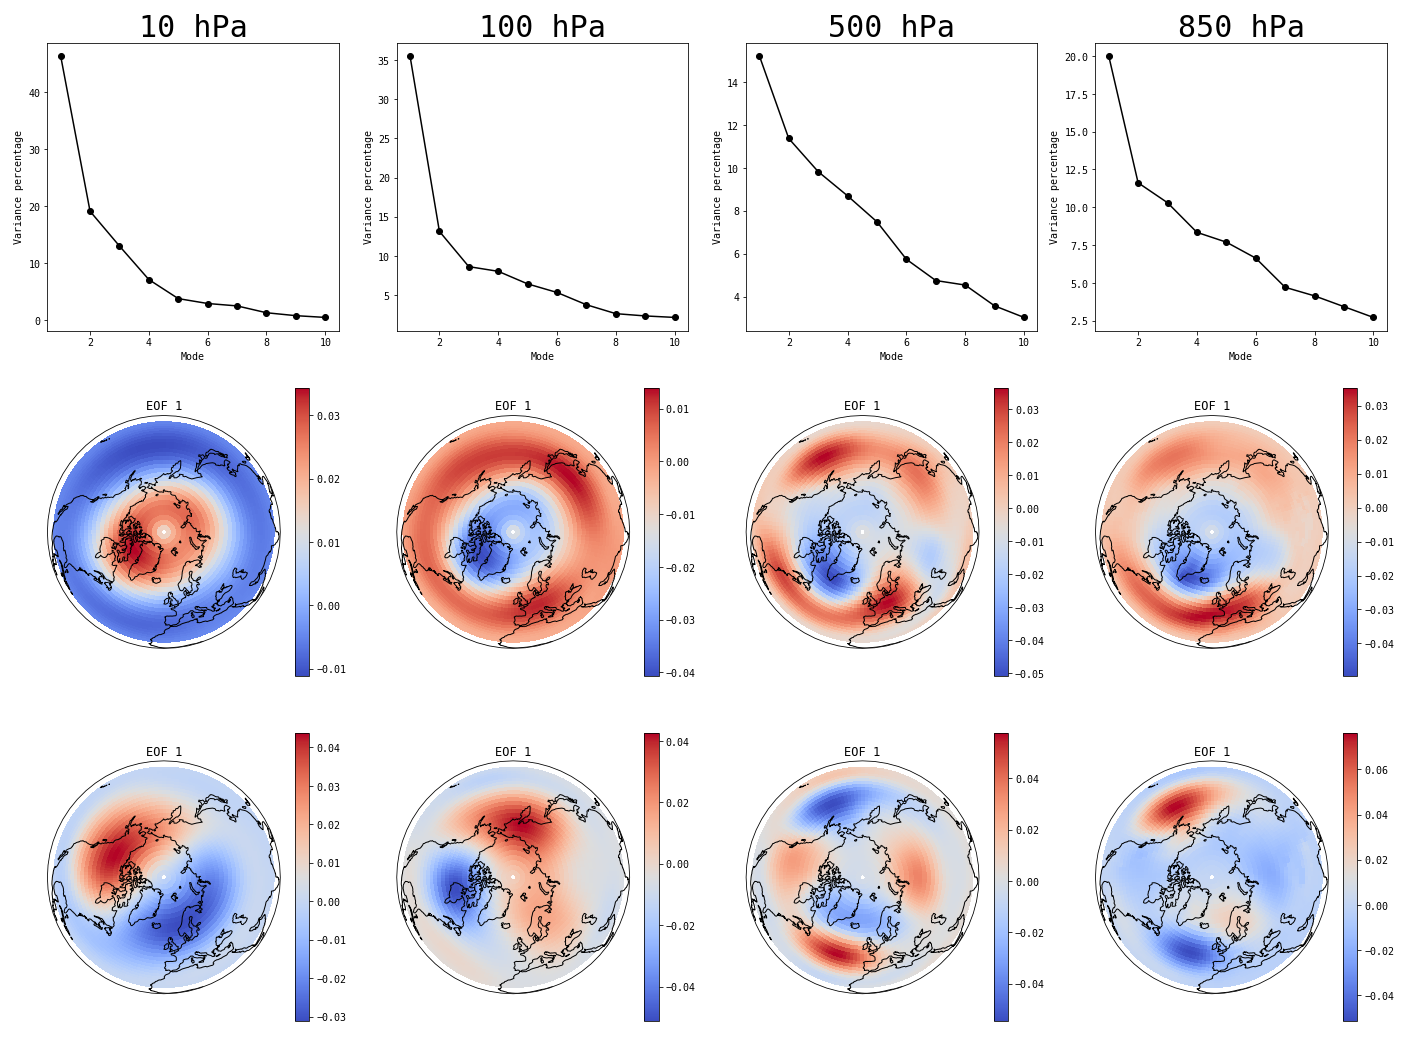

In [10]:
fig = matplotlib.pyplot.figure(figsize=(24,18))
eofs, variance_fraction = ds_eofs["eofs"], ds_eofs["variance_fraction"]
for i_lev in range(4):
    # Plot singular value spectrum
    ax = fig.add_subplot(3,4,i_lev+1)
    vf = variance_fraction.isel(level=i_lev)
    ax.plot(variance_fraction.mode, 100*variance_fraction.isel(level=i_lev), marker='o', color='black')
    ax.set_xlabel("Mode")
    ax.set_ylabel("Variance percentage")
    ax.set_title(f"{variance_fraction.level.data[i_lev]} hPa", font={"size": 30})
    # Plot EOF 1
    ax = fig.add_subplot(3,4,4+i_lev+1,projection=ccrs.Orthographic(-10,90))
    xr_utils.display_pole_field(eofs.sel(mode=1).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    # Plot EOF 2
    ax = fig.add_subplot(3,4,8+i_lev+1,projection=ccrs.Orthographic(-10,90))
    xr_utils.display_pole_field(eofs.sel(mode=2).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    

## Read database and compute features. 

In [11]:
reload(feature_stratosphere)
reload(xr_utils)

<module 'xr_utils' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/xr_utils.py'>

In [12]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

Specify any feature definitions

In [13]:
featdef = {"ds_eofs": ds_eofs, "ds_monclim": ds_monclim}

In [ ]:
# ------------------- Fix the bug -----------------------------
input_dir = filedict["data"]["e5"]["traj"]["dir"]
input_file_list = [f for f in os.listdir(input_dir) if f.startswith("196")]
obs_dict = {"time_observable": [], "ubar_observable": []}
for i_file in range(len(input_file_list)):
    ds = xr.open_dataset(join(input_dir, input_file_list[i_file]))
    ds.close()
    ds = feat_strat.preprocess_netcdf(ds, "e5")
    obs_dict["time_observable"] += [feat_strat.time_observable(ds, "e5")]
    obs_dict["ubar_observable"] += [feat_strat.ubar_observable(ds, "e5")]

t_sim_offsets = (tobscat["t_init"] - tobscat["t_init"][0])/feat_strat.time_unit
t_sim_new_presort = t_sim_offsets + tobscat["t_sim"]
t_sim_new = np.sort((t_sim_new_presort).to_numpy().flatten())

ds_obs = dict()
for key in ["time_observable","ubar_observable"]:
    obscat = xr.concat(obs_dict["time_observable"], dim="t_init").sortby("t_init")
    ds_obs[key] = (
        obscat.stack(t_new=('t_init','t_sim'))
        .transpose('t_new','feature')
        .assign_coords({"t_new": t_sim_new})
        .rename({"t_new": "t_sim"})
    )
    nonnan_idx, = np.where(np.isnan(ds_obs[key]).sum(dim="feature") == 0)
    ds_obs[key] = ds_obs[key].isel(t_sim=nonnan_idx)

In [14]:
obs2compute = [
    "time_observable", "ubar_observable", "pc_observable", 
    "temperature_observable", "heatflux_observable",
    "qbo_observable",
]
for src in ["e5"]:
    obs_dict = dict({obsname: [] for obsname in obs2compute})
    input_dir = filedict["data"][src]["traj"]["dir"]
    input_file_list = [f for f in os.listdir(input_dir) if f.endswith(".nc")]
    output_dir = filedict["data"][src]["feat_all"]["dir"]
    feat_strat.compute_all_features(
        src, input_dir, input_file_list, output_dir, 
        featdef, obs2compute=obs2compute
    )

Beginning file 0/732
	----Times--- 
	opening/processing file 0:00:00.106389
	time obs 0:00:00.011290
	ubar obs 0:00:00.007229
	vT obs 0:00:00.033299
	temp obs 0:00:00.009137
	pc obs 0:00:00.096370
	qbo obs 0:00:00.005788
Beginning file 5/732
	----Times--- 
	opening/processing file 0:00:00.111979
	time obs 0:00:00.011073
	ubar obs 0:00:00.006953
	vT obs 0:00:00.032842
	temp obs 0:00:00.009783
	pc obs 0:00:00.102254
	qbo obs 0:00:00.006094
Beginning file 10/732
	----Times--- 
	opening/processing file 0:00:00.110980
	time obs 0:00:00.010438
	ubar obs 0:00:00.006747
	vT obs 0:00:00.031094
	temp obs 0:00:00.008871
	pc obs 0:00:00.091393
	qbo obs 0:00:00.006047
Beginning file 15/732
	----Times--- 
	opening/processing file 0:00:00.083152
	time obs 0:00:00.010460
	ubar obs 0:00:00.006732
	vT obs 0:00:00.031847
	temp obs 0:00:00.008872
	pc obs 0:00:00.095416
	qbo obs 0:00:00.005664
Beginning file 20/732
	----Times--- 
	opening/processing file 0:00:00.103464
	time obs 0:00:00.010512
	ubar obs 0:

Reload the TPT features as a dictionary. We don't yet put them in a single dataset in order to avoid dimension conflicts. 

In [15]:
feat_all = dict()
for src in ["s2","e5"]:
    feat_all[src] = feat_strat.assemble_all_features(
        filedict["data"][src]["feat_all"]["dir"],
        obs2assemble = [
            "time_observable", "ubar_observable", "pc_observable", 
            "temperature_observable", "heatflux_observable",
            "qbo_observable",
            ]
        )

In [16]:
feat_all["e5"]["time_observable"].sel(feature="t_abs").shape

(22280,)

In [17]:
31*12*61

22692

Plot some climatological envelopes, as well as some hindcast ensembles from the same year 

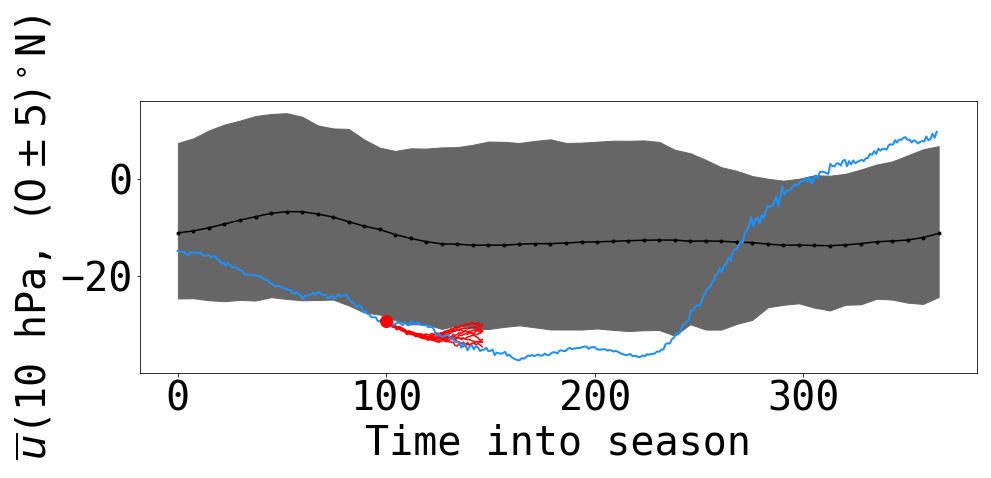

In [29]:
fig,ax = plt.subplots(figsize=(15,5))

year2plot = 2006
obs_group = "qbo_observable"
obs_name = "ubar_10_0pm5"
obs_label = "$\overline{u}$(10 hPa, $(0\pm5)^\circ$N)"
t_init_target = 100.0 # How many days into the season
i_t_init = int(t_init_target / 3.5)

cond_e5 = 1*(feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == year2plot)
cond_s2 = 1*(feat_all["s2"]["time_observable"].isel(t_sim=0).sel(feature="year_szn_start") == year2plot)

tpt_utils.plot_field_1d(
    feat_all["e5"][obs_group].sel(feature=obs_name).to_numpy(), 
    np.ones(feat_all["e5"][obs_group].t_sim.size), 
    feat_all["e5"]["time_observable"].sel(feature="t_szn").to_numpy(),
    feat_name="Time into season", field_name=obs_label,
    fig=fig, ax=ax, nbins=50
)
for i_mem in range(feat_all["s2"]["time_observable"].member.size):
    x_ens, = feat_all["s2"]["time_observable"].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature="t_szn").to_numpy(),
    y_ens, = feat_all["s2"][obs_group].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature=obs_name).to_numpy(),
    ax.plot(x_ens, y_ens, color='red')
    if i_mem == 0: ax.scatter(x_ens[0], y_ens[0], color='red', marker='o', zorder=10, s=144)
    
ax.plot(
    feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").to_numpy(),
    feat_all["e5"][obs_group].where(cond_e5,drop=True).sel(feature=obs_name).to_numpy(),
    color='dodgerblue', linewidth=2
)


Plot some two-dimensional densities, at multiple time slices throughout the season.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='u_10_60', ylabel='pc_10_2'>)

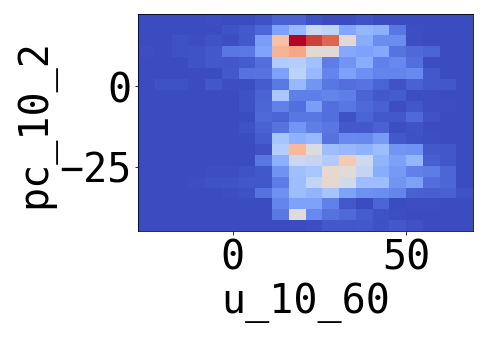

In [30]:
fig,ax = plt.subplots()
cond = 1*(
    (feat_all["e5"]["time_observable"].sel(feature="t_szn") > 0) * 
    (feat_all["e5"]["time_observable"].sel(feature="t_szn") < 100)
)
tpt_utils.plot_field_2d(
    np.ones(feat_all["e5"]["time_observable"].where(cond,drop=True).t_sim.size), 
    np.ones(feat_all["e5"]["time_observable"].where(cond,drop=True).t_sim.size),
    np.array([
        feat_all["e5"]["ubar_observable"].where(cond,drop=True).sel(feature="ubar_10_60").to_numpy(),
        feat_all["e5"]["qbo_observable"].where(cond,drop=True).sel(feature="ubar_10_0pm5").to_numpy(),        
    ]).T,
    feat_names = ["u_10_60", "pc_10_2"],
    fig=fig, ax=ax, shp=[20,20],
    stat_name="weightsum"
)

# Assemble features for TPT.

In [64]:
reload(feature_stratosphere)
reload(xr_utils)

<module 'xr_utils' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/xr_utils.py'>

In [65]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

In [ ]:
for src in ["s2","e5"]:
    feat_strat.assemble_tpt_features(feat_all[src], filedict["data"][src]["feat_tpt"]["dir"])

In [70]:
feat_tpt = dict()
for src in ["s2","e5"]:
    feat_tpt[src] = xr.open_dataarray(join(filedict["data"][src]["feat_tpt"]["dir"], "features_tpt.nc"))

In [80]:
feat_tpt["e5"].dims

('feature', 't_sim')

# Compute the source and destination: A and B 

In [114]:
reload(feature_template)

<module 'feature_template' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/../../feature_template.py'>

In [115]:
reload(feature_stratosphere)

<module 'feature_stratosphere' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/feature_stratosphere.py'>

In [116]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

## Estimate return time for a range of different parameters

In [117]:
feat_strat.set_ab_boundaries(40, 150, 0.0)

In [118]:
feat_tpt["s2"].coords

Coordinates:
  * t_init   (t_init) datetime64[ns] 1996-07-04 1996-07-07 ... 2016-06-29
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10
  * t_sim    (t_sim) float64 0.0 1.0 2.0 3.0 4.0 ... 42.0 43.0 44.0 45.0 46.0
  * feature  (feature) object 't_abs' 't_szn' ... 'ubar_10_0pm5' 'ubar_100_0pm5'

In [119]:
feat_tpt[src].coords

Coordinates:
  * feature  (feature) object 't_abs' 't_szn' ... 'ubar_10_0pm5' 'ubar_100_0pm5'
  * t_sim    (t_sim) float64 0.0 1.0 2.0 3.0 ... 2.228e+04 2.228e+04 2.228e+04

In [120]:
ab_tag = dict()
cej = dict() # Hitting times (Cotton-eye Joe)
comm_emp = dict() # Empirical committor: to B in forward time, from A in backward time
rate_emp = dict() # Empirical rate estimate 
for src in ["e5","s2"]:
    ab_tag[src] = feat_strat.ab_test(feat_tpt[src])
    mode = "timechunks" if src == "e5" else "timesteps" # This determines the computation pattern for iterating through the dataset
    cej[src] = feat_strat.cotton_eye_joe(feat_tpt[src],ab_tag[src],mode=mode)
    comm_emp[src] = feat_strat.estimate_empirical_committor(cej[src])
    rate_emp[src] = feat_strat.estimate_rate(cej[src], comm_emp[src])
    # Save each item
    ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
    cej[src].to_netcdf(join(filedict["results"]["dir"], f"cej_{src}.nc"))    
    comm_emp[src].to_netcdf(join(filedict["results"]["dir"], f"comm_emp_{src}.nc"))
    rate_emp[src].to_netcdf(join(filedict["results"]["dir"], f"rate_emp_{src}.nc"))


t_sim.shape = (22280,)


KeyError: 't_init'

Plot the return level vs. return time for minimum U1060. Is there some natural way to do this just using A and B definitions? 

In [ ]:
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][1]) 
)
field = feat_tpt["ra"].sel(sel,drop=True).where(cond,drop=True).sel(feature="ubar_10_60_delay0",drop=True).to_numpy().reshape(-1,1)
weights = np.ones_like(field)
year_szn_start = (
    feat_tpt["ra"].sel(sel,drop=True)
    .where(cond,drop=True).
    sel(feature="year_szn_start",drop=True).
    to_numpy().
    reshape(-1,1).astype(int)
)
bounds = np.array([[np.min(year_szn_start)-0.5], [np.max(year_szn_start)+0.5]])
shp = (np.round(bounds[1] - bounds[0])).astype(int)
ubar_yearly_stats, edges, centers = tpt_utils.project_field(  
    field, weights, year_szn_start, shp=shp, bounds=bounds
)

In [ ]:
# Function to compute return period for a list of block minima
neg_umin = -ubar_yearly_stats['min'].flatten()
order = np.argsort(neg_umin)
rank = np.argsort(order)
cdf_emp = rank / len(neg_umin)
ret_emp = 1.0/(1 - cdf_emp)

In [ ]:
fig,ax = plt.subplots()
idx, = np.where(neg_umin > 0)
ax.scatter(ret_emp[idx], neg_umin[idx], color='black', marker='.') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([1,5,10,20,30])
ax.set_yticklabels([1,5,10,20,30])
ax.set_xticks([1, 5, 10, 25, 50])
ax.set_xticklabels([1, 5, 10, 25, 50])
ax.set_xlabel("Return period (years)", font={"size": 18})
ax.set_ylabel("$-\min(\overline{u})$", font={"size": 18})

## Plot some pictures of the committor 

In [ ]:
fig,axes = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
years2plot = np.arange(1984,1992)
tidx, = np.where(np.in1d(feat_tpt["ra"].sel(feature="year_szn_start").to_numpy(), years2plot))
isel = dict(ensemble=0,member=0, t_sim=tidx)
h_ubar, = xr.plot.plot(
    feat_tpt["ra"].isel(isel,drop=True).sel(feature="vT_100_1_runavg15"),
    color="black",ax=axes[0],label="$u1060$",x="t_sim"
)
handles = []
for set_code in ["A","B"]:
    color = "dodgerblue" if set_code == "A" else "red"
    starts, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == 1)
    ends, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == -1)
    if starts[0] > ends[0]: 
        ends = ends[1:]
    if starts[-1] > ends[-1]:
        starts = starts[:-1]
    for i in range(len(starts)):
        axes[0].axvspan(
            feat_tpt["ra"]["t_sim"][tidx[starts[i]]], feat_tpt["ra"]["t_sim"][tidx[ends[i]]], 
            color=color, alpha=0.5, zorder=-1
        )
    h_hittime, = xr.plot.plot(
        cej["ra"].isel(isel,drop=True).sel(state=set_code, sense="until", drop=True),
        ax=axes[1], label=r"$\tau_%s^+$"%(set_code), color=color)
    handles += [h_hittime]

axes[0].axhline(y=feat_strat.tpt_bndy["ubar_10_60_thresh"], color='black')
axes[0].legend(handles=[h_ubar], prop={"size": 18})
axes[1].legend(handles=handles, prop={"size": 18})


In [ ]:
feat = "pc_10_3" # The independent variable
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0]+50) 
)
# Committor
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
# Next hitting time
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()
tpt_utils.plot_field_1d(
    qp, np.ones(qp.size), 
    feat_tpt["ra"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1], feat_name=feat, field_name="Committor to B"
)
tpt_utils.plot_field_1d(
    -Tb, qp, 
    feat_tpt["ra"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)


In [ ]:
# Choose the two features
feat0,feat1 = "ubar_10_60_delay0","ubar_10_60_delay10"
# Select the first ensemble and member (trivial for reanalysis: there's only one realization)
sel = dict(ensemble=0,member=0) 
# Take a slice of the season, between two times
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0] + 50) 
)
# Call the committor qp (q-plus) and the hitting time to B Tb
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
# First plot: committor
tpt_utils.plot_field_2d(
    qp, # function values
    np.ones(feat_tpt["ra"]["t_sim"].size), # weights
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True), # Feature space
    feat_names = [feat0,feat1],  # axis labels
    shp=[20,20], # shape of the 2D grid controls how pixellated the image is
    fig=fig, ax=axes[0], field_name=r"$q_B^+$" #other display parameters
)
# Second plot: hitting time (negative, so it increases towards B)
tpt_utils.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[1], field_name=r"$-\tau_B^+$"
)
# Third plot: hitting time conditioned on hitting B first
tpt_utils.plot_field_2d(
    -Tb*qp,
    qp,
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[2], field_name=r"$-\eta_B^+$"
)


# Estimate the rate from ERA5. 

And include error bars. This time, we will plot return period as a function of return level.